In [1]:
import pandas as pd
from pathlib import Path
import random
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tifffile as tiff
import cv2

data_path = Path('/kaggle/input/')
TRAIN_PATH= str(data_path) + "/hubmap-organ-segmentation/train_images/"


In [2]:
train_df = pd.read_csv(data_path/ 'hubmap-organ-segmentation/train.csv')
train_df.head()


,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female


In [3]:
# functions to convert encoding to mask and mask to encoding
# https://www.kaggle.com/paulorzp/rle-functions-run-length-encode-decode
def mask2rle(img): # encoder
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
 
def rle2mask(mask_rle, shape=(1600,256)): # decoder
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

def get_image_data(df, im_path):
    """
    :param df: DataFrame with dataset data
    :param im_path: path to image
    :return: id, encoded mask, height and width of image
    """
    id_ = int(im_path.split("/")[-1].split(".")[0]) # image id
    data = df[df['id'] == int(id_)] # dataframe row from image
    mask_rle = data['rle'].iat[0]
    height = data['img_height'].iat[0]
    width = data['img_width'].iat[0]
    return id_, mask_rle, height, width

In [4]:
# rescale to a desire img size
# keep in mide that the size needs to be large enough
# to keep all important features for model training
def rescale(img, mask, size=(2048,2048)):
    scaled_img = cv2.resize(img, size)
    scaled_mask = cv2.resize(mask, size, interpolation=cv2.INTER_NEAREST)
    return scaled_img, scaled_mask

In [5]:
def thresholding(img, method='otsu'):
    # convert to grayscale complement image
    grayscale_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_c = 255 - grayscale_img
    thres, thres_img = 0, img_c.copy()
    if method == 'otsu':
        thres, thres_img = cv2.threshold(img_c, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    elif method == 'triangle':
        thres, thres_img = cv2.threshold(img_c, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_TRIANGLE)
    return thres, thres_img, img_c

In [6]:
# adapted from: https://www.kaggle.com/code/analokamus/a-fast-tile-generation
def make_tiles(img, mask, tile_size=256):
    '''
    img: np.ndarray with dtype np.uint8 and shape (width, height, channel)
    mask: np.ndarray with dtype np.uint9 and shape (width, height)
    '''
    w_i, h_i, ch = img.shape
    w_m, h_m     = mask.shape
    
    pad0, pad1 = (tile_size - w_i%tile_size) % tile_size, (tile_size - h_i%tile_size) % tile_size
    
    padding_i = [[pad0//2, pad0-pad0//2], [pad1//2, pad1-pad1//2], [0, 0]]
    padding_m = [[pad0//2, pad0-pad0//2], [pad1//2, pad1-pad1//2]]
    
    img = np.pad(img, padding_i, mode='constant', constant_values=255)
    img = img.reshape(img.shape[0]//tile_size, tile_size, img.shape[1]//tile_size, tile_size, ch)
    img = img.transpose(0, 2, 1, 3, 4).reshape(-1, tile_size, tile_size, ch)
    
    mask = np.pad(mask, padding_m, mode='constant', constant_values=255)
    mask = mask.reshape(mask.shape[0]//tile_size, tile_size, mask.shape[1]//tile_size, tile_size)
    mask = mask.transpose(0, 2, 1, 3).reshape(-1, tile_size, tile_size)
    
    num_tiles = len(mask)
    #     if len(img) < num_tiles: # pad images so that the output shape be the same
    #         padding = [[0, num_tiles-len(img)], [0, 0], [0, 0], [0, 0]]
    #         img = np.pad(img, padding, mode='constant', constant_values=255)
    #idxs = np.argsort(img.reshape(img.shape[0], -1).sum(-1))[:num_tiles] # pick up Top N dark tiles
    #img = img[idxs]
    return img, mask

In [7]:
def get_tiles(im, mask, size):
    """
    :param im: image
    :param mask: decoded mask of image
    :param size: height and width of tile
    :return: every tile of image, decoded mask and size idxs of such
    """
    w = h = size
    # https://stackoverflow.com/a/47581978/4521646
    im_tiles = [im[i:(i + h), j:(j + w), ...] for i in range(0, im.shape[0], h) for j in range(0, im.shape[1], w)]
    mask_tiles = [mask[i:(i + h), j:(j + w), ...] for i in range(0, im.shape[0], h) for j in range(0, im.shape[1], w)]
    idxs_tiles = [(i, (i + h), j, (j + w)) for i in range(0, im.shape[0], h) for j in range(0, im.shape[1], w)]
    # fill border tiles to have same size on every tile
    for k, (im_tile, mask_tile) in enumerate(zip(im_tiles, mask_tiles)):
        if im_tile.shape[:2] != (h, w):
            im_tile_ = im_tile
            mask_tile_ = mask_tile
            im_tile = np.zeros_like(im_tiles[0])
            mask_tile = np.zeros_like(mask_tiles[0])
            im_tile[:im_tile_.shape[0], :im_tile_.shape[1], ...] = im_tile_
            mask_tile[:mask_tile_.shape[0], :mask_tile_.shape[1], ...] = mask_tile_
            im_tiles[k] = im_tile
            mask_tiles[k] = mask_tile
    #print(idxs_tiles)
    return im_tiles, mask_tiles, idxs_tiles

In [8]:
full_img_size=3000

In [9]:
def tile_saving(ID, df, thres, img_folder, mask_folder, rescale_size=(2048,2048), tile_size=512):
    # load original img and mask
    img  = tiff.imread(TRAIN_PATH + str(ID) +'.tiff')
    mask = rle2mask(df.loc[df['id'] == ID].rle.values[0], (full_img_size, full_img_size))
    
    # rescale to 2048x2048
    scaled_img, scaled_mask = rescale(img, mask, size=rescale_size)
    
    # make tiles + select based on given threshold
    img_tiles, mask_tiles, idxs_tiles = get_tiles(scaled_img, scaled_mask, tile_size)
    rle_mask_tiles = [mask2rle(mask_tiles) for mask_tiles in mask_tiles]
    
    #print(idxs_tiles)
    selected_tiles = 0
    for i, (img_crop,rle_mask_tile,idx_tiles) in tqdm(enumerate(zip(img_tiles,rle_mask_tiles,idxs_tiles))):
        
        img_c = 255-img_crop # image complement
        if len(rle_mask_tile.strip()):
            if img_c.mean() > thres   : # pixel value mean greater threshold -> select tile 
                selected_tiles+=1
                tiles_data.append([ID, i, rle_mask_tile,idx_tiles])
                cv2.imwrite(os.path.join(img_folder,f'{ID}_{i}.png'), img_crop)
                cv2.imwrite(os.path.join(mask_folder, f'{ID}_{i}.png'), mask_tiles[i])
    print('-------------Done------------')
    #print('Hi')
    #print(selected_tiles)

**Creating different folder for train and mask to store the images after tiling**

In [10]:
!mkdir train train/image train/mask
img_folder  = './train/image'
mask_folder = './train/mask'



In [11]:
import glob
from tqdm import tqdm
import os
import math

In [12]:
tile_size=512

images_path = glob.glob("/kaggle/input/hubmap-organ-segmentation/train_images/*.tiff")

tiles_data=[]
for im_path in tqdm(images_path):
    id_, mask_rle, height, width = get_image_data(train_df, im_path)
    
    img_test = tiff.imread(f'/kaggle/input/hubmap-organ-segmentation/train_images/{id_}.tiff')
    thres_otsu, thres_img, img_c = thresholding(img_test, method='otsu')
    
    
    tiles_data.append(tile_saving(id_, train_df, thres_otsu, img_folder, mask_folder, tile_size=512))


  0%|          | 0/351 [00:00<?, ?it/s]
16it [00:00, 2591.58it/s]
  0%|          | 1/351 [00:00<04:09,  1.40it/s]

-------------Done------------



16it [00:00, 220.73it/s]
  1%|          | 2/351 [00:01<04:07,  1.41it/s]

-------------Done------------



16it [00:00, 570.07it/s]
  1%|          | 3/351 [00:01<03:31,  1.65it/s]

-------------Done------------



16it [00:00, 3214.64it/s]
  1%|          | 4/351 [00:02<02:59,  1.93it/s]

-------------Done------------



16it [00:00, 200.75it/s]
  1%|▏         | 5/351 [00:02<02:59,  1.93it/s]

-------------Done------------



16it [00:00, 618.83it/s]
  2%|▏         | 6/351 [00:03<02:46,  2.07it/s]

-------------Done------------



16it [00:00, 209.16it/s]
  2%|▏         | 7/351 [00:03<02:37,  2.18it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 150.54it/s]
  2%|▏         | 8/351 [00:04<02:32,  2.25it/s]

-------------Done------------



16it [00:00, 1773.02it/s]
  3%|▎         | 9/351 [00:04<02:25,  2.36it/s]

-------------Done------------



16it [00:00, 3208.19it/s]
  3%|▎         | 10/351 [00:04<02:14,  2.53it/s]

-------------Done------------



16it [00:00, 281.39it/s]
  3%|▎         | 11/351 [00:05<02:16,  2.49it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 105.18it/s][A
  3%|▎         | 12/351 [00:05<02:25,  2.34it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 120.57it/s]
  4%|▎         | 13/351 [00:06<02:27,  2.29it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 134.43it/s][A
  4%|▍         | 14/351 [00:06<02:32,  2.21it/s]

-------------Done------------



16it [00:00, 243.45it/s]
  4%|▍         | 15/351 [00:07<02:28,  2.27it/s]

-------------Done------------



16it [00:00, 2695.24it/s]
  5%|▍         | 16/351 [00:07<02:20,  2.39it/s]

-------------Done------------



16it [00:00, 211.70it/s]
  5%|▍         | 17/351 [00:07<02:16,  2.45it/s]

-------------Done------------



16it [00:00, 165.33it/s]
  5%|▌         | 18/351 [00:08<02:19,  2.39it/s]

-------------Done------------



16it [00:00, 411.62it/s]
  5%|▌         | 19/351 [00:08<02:14,  2.47it/s]

-------------Done------------



16it [00:00, 692.39it/s]
  6%|▌         | 20/351 [00:08<02:13,  2.47it/s]

-------------Done------------



16it [00:00, 425.73it/s]
  6%|▌         | 21/351 [00:09<02:14,  2.46it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 132.98it/s]
  6%|▋         | 22/351 [00:09<02:24,  2.28it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 73.02it/s]
  7%|▋         | 23/351 [00:10<02:52,  1.91it/s]

-------------Done------------



16it [00:00, 193.04it/s]
  7%|▋         | 24/351 [00:11<02:49,  1.93it/s]

-------------Done------------



16it [00:00, 192.56it/s]
  7%|▋         | 25/351 [00:11<02:50,  1.91it/s]

-------------Done------------



16it [00:00, 166.23it/s]
  7%|▋         | 26/351 [00:12<02:46,  1.95it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 96.29it/s][A
  8%|▊         | 27/351 [00:12<02:46,  1.95it/s]

-------------Done------------



16it [00:00, 372.49it/s]
  8%|▊         | 28/351 [00:13<02:41,  2.00it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 140.53it/s]
  8%|▊         | 29/351 [00:13<02:38,  2.04it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 136.98it/s]
  9%|▊         | 30/351 [00:14<02:37,  2.03it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 86.42it/s]
  9%|▉         | 31/351 [00:14<02:39,  2.00it/s]

-------------Done------------



16it [00:00, 211.66it/s]
  9%|▉         | 32/351 [00:15<02:33,  2.08it/s]

-------------Done------------



16it [00:00, 261.84it/s]
  9%|▉         | 33/351 [00:15<02:26,  2.17it/s]

-------------Done------------



16it [00:00, 401.37it/s]
 10%|▉         | 34/351 [00:15<02:17,  2.30it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 72.07it/s][A
 10%|▉         | 35/351 [00:16<02:26,  2.16it/s]

-------------Done------------



16it [00:00, 265.81it/s]
 10%|█         | 36/351 [00:16<02:26,  2.15it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 122.36it/s]
 11%|█         | 37/351 [00:17<02:26,  2.14it/s]

-------------Done------------



16it [00:00, 194.30it/s]
 11%|█         | 38/351 [00:17<02:26,  2.13it/s]

-------------Done------------



16it [00:00, 386.88it/s]
 11%|█         | 39/351 [00:18<02:18,  2.25it/s]

-------------Done------------



16it [00:00, 254.30it/s]
 11%|█▏        | 40/351 [00:18<02:18,  2.24it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 86.86it/s]
 12%|█▏        | 41/351 [00:19<02:22,  2.17it/s]

-------------Done------------



16it [00:00, 4163.34it/s]
 12%|█▏        | 42/351 [00:19<02:16,  2.27it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 125.32it/s]
 12%|█▏        | 43/351 [00:20<02:20,  2.20it/s]

-------------Done------------



16it [00:00, 359.10it/s]
 13%|█▎        | 44/351 [00:20<02:14,  2.28it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 115.96it/s]
 13%|█▎        | 45/351 [00:20<02:15,  2.26it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 107.69it/s][A
 13%|█▎        | 46/351 [00:21<02:27,  2.07it/s]

-------------Done------------



16it [00:00, 213.77it/s]
 13%|█▎        | 47/351 [00:21<02:27,  2.07it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 106.52it/s]
 14%|█▎        | 48/351 [00:22<02:27,  2.05it/s]

-------------Done------------



16it [00:00, 170.22it/s]
 14%|█▍        | 49/351 [00:22<02:26,  2.07it/s]

-------------Done------------



16it [00:00, 196.01it/s]
 14%|█▍        | 50/351 [00:23<02:21,  2.13it/s]

-------------Done------------



16it [00:00, 736.54it/s]
 15%|█▍        | 51/351 [00:23<02:16,  2.20it/s]

-------------Done------------



16it [00:00, 267.35it/s]
 15%|█▍        | 52/351 [00:24<02:15,  2.21it/s]

-------------Done------------



0it [00:00, ?it/s]
8it [00:00, 77.37it/s]
16it [00:00, 68.62it/s]
 15%|█▌        | 53/351 [00:24<02:22,  2.09it/s]

-------------Done------------



16it [00:00, 2745.30it/s]
 15%|█▌        | 54/351 [00:25<02:11,  2.25it/s]

-------------Done------------



16it [00:00, 167.06it/s]
 16%|█▌        | 55/351 [00:25<02:11,  2.26it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 117.45it/s]
 16%|█▌        | 56/351 [00:26<02:17,  2.15it/s]

-------------Done------------



16it [00:00, 2032.00it/s]
 16%|█▌        | 57/351 [00:26<02:06,  2.32it/s]

-------------Done------------



16it [00:00, 395.19it/s]
 17%|█▋        | 58/351 [00:26<02:01,  2.40it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 81.40it/s][A
 17%|█▋        | 59/351 [00:27<02:03,  2.36it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 144.55it/s]
 17%|█▋        | 60/351 [00:27<02:06,  2.31it/s]

-------------Done------------



16it [00:00, 369.93it/s]
 17%|█▋        | 61/351 [00:28<02:04,  2.32it/s]

-------------Done------------



16it [00:00, 2101.55it/s]
 18%|█▊        | 62/351 [00:28<01:57,  2.47it/s]

-------------Done------------



16it [00:00, 199.37it/s]
 18%|█▊        | 63/351 [00:28<01:59,  2.41it/s]

-------------Done------------



16it [00:00, 389.12it/s]
 18%|█▊        | 64/351 [00:29<01:57,  2.45it/s]

-------------Done------------



16it [00:00, 364.17it/s]
 19%|█▊        | 65/351 [00:29<01:56,  2.46it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 139.92it/s]
 19%|█▉        | 66/351 [00:30<02:00,  2.37it/s]

-------------Done------------



16it [00:00, 163.17it/s]
 19%|█▉        | 67/351 [00:30<02:03,  2.30it/s]

-------------Done------------



16it [00:00, 258.09it/s]
 19%|█▉        | 68/351 [00:31<01:59,  2.36it/s]

-------------Done------------



16it [00:00, 193.28it/s]
 20%|█▉        | 69/351 [00:31<02:01,  2.32it/s]

-------------Done------------



16it [00:00, 381.03it/s]
 20%|█▉        | 70/351 [00:31<02:01,  2.31it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 117.18it/s][A
 20%|██        | 71/351 [00:32<02:17,  2.04it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 95.66it/s]
 21%|██        | 72/351 [00:32<02:14,  2.08it/s]

-------------Done------------



16it [00:00, 183.46it/s]
 21%|██        | 73/351 [00:33<02:13,  2.09it/s]

-------------Done------------



16it [00:00, 1882.44it/s]
 21%|██        | 74/351 [00:33<02:05,  2.20it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 104.14it/s][A
 21%|██▏       | 75/351 [00:34<02:08,  2.15it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 100.25it/s][A
 22%|██▏       | 76/351 [00:34<02:02,  2.24it/s]

-------------Done------------



16it [00:00, 1694.71it/s]
 22%|██▏       | 77/351 [00:35<01:56,  2.35it/s]

-------------Done------------



16it [00:00, 375.61it/s]
 22%|██▏       | 78/351 [00:35<01:52,  2.42it/s]

-------------Done------------



16it [00:00, 271.10it/s]
 23%|██▎       | 79/351 [00:35<01:52,  2.42it/s]

-------------Done------------



0it [00:00, ?it/s]
7it [00:00, 66.45it/s]
16it [00:00, 62.87it/s]
 23%|██▎       | 80/351 [00:36<02:05,  2.16it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 104.08it/s][A
 23%|██▎       | 81/351 [00:37<02:12,  2.04it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 90.83it/s]
 23%|██▎       | 82/351 [00:37<02:09,  2.08it/s]

-------------Done------------



16it [00:00, 197.51it/s]
 24%|██▎       | 83/351 [00:37<02:05,  2.14it/s]

-------------Done------------



16it [00:00, 344.04it/s]
 24%|██▍       | 84/351 [00:38<01:59,  2.23it/s]

-------------Done------------



16it [00:00, 533.47it/s]
 24%|██▍       | 85/351 [00:38<01:52,  2.36it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 101.94it/s]
 25%|██▍       | 86/351 [00:39<02:00,  2.21it/s]

-------------Done------------



16it [00:00, 183.33it/s]
 25%|██▍       | 87/351 [00:39<01:58,  2.23it/s]

-------------Done------------



16it [00:00, 3069.52it/s]
 25%|██▌       | 88/351 [00:39<01:45,  2.49it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 138.14it/s]
 25%|██▌       | 89/351 [00:40<01:48,  2.42it/s]

-------------Done------------



16it [00:00, 290.30it/s]
 26%|██▌       | 90/351 [00:40<01:44,  2.49it/s]

-------------Done------------



16it [00:00, 207.65it/s]
 26%|██▌       | 91/351 [00:41<01:47,  2.43it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 129.56it/s]
 26%|██▌       | 92/351 [00:41<01:53,  2.27it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 106.37it/s]
 26%|██▋       | 93/351 [00:42<02:05,  2.06it/s]

-------------Done------------



16it [00:00, 404.63it/s]
 27%|██▋       | 94/351 [00:42<01:57,  2.19it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 76.88it/s]
 27%|██▋       | 95/351 [00:43<02:00,  2.13it/s]

-------------Done------------



16it [00:00, 315.55it/s]
 27%|██▋       | 96/351 [00:43<01:58,  2.14it/s]

-------------Done------------



16it [00:00, 2008.23it/s]
 28%|██▊       | 97/351 [00:44<01:49,  2.32it/s]

-------------Done------------



16it [00:00, 2973.63it/s]
 28%|██▊       | 98/351 [00:44<01:41,  2.49it/s]

-------------Done------------



16it [00:00, 604.55it/s]
 28%|██▊       | 99/351 [00:44<01:39,  2.53it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 139.06it/s]
 28%|██▊       | 100/351 [00:45<01:41,  2.48it/s]

-------------Done------------



16it [00:00, 253.40it/s]
 29%|██▉       | 101/351 [00:45<01:40,  2.48it/s]

-------------Done------------



16it [00:00, 388.88it/s]
 29%|██▉       | 102/351 [00:45<01:39,  2.51it/s]

-------------Done------------



16it [00:00, 351.66it/s]
 29%|██▉       | 103/351 [00:46<01:38,  2.52it/s]

-------------Done------------



16it [00:00, 641.97it/s]
 30%|██▉       | 104/351 [00:46<01:36,  2.57it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 96.57it/s]
 30%|██▉       | 105/351 [00:47<01:46,  2.31it/s]

-------------Done------------



16it [00:00, 206.44it/s]
 30%|███       | 106/351 [00:47<01:47,  2.27it/s]

-------------Done------------



16it [00:00, 194.76it/s]
 30%|███       | 107/351 [00:48<01:48,  2.24it/s]

-------------Done------------



16it [00:00, 562.97it/s]
 31%|███       | 108/351 [00:48<01:43,  2.35it/s]

-------------Done------------



16it [00:00, 668.30it/s]
 31%|███       | 109/351 [00:48<01:44,  2.31it/s]

-------------Done------------



16it [00:00, 205.17it/s]
 31%|███▏      | 110/351 [00:49<01:43,  2.34it/s]

-------------Done------------



16it [00:00, 204.02it/s]
 32%|███▏      | 111/351 [00:49<01:42,  2.35it/s]

-------------Done------------



16it [00:00, 261.59it/s]
 32%|███▏      | 112/351 [00:50<01:41,  2.36it/s]

-------------Done------------



16it [00:00, 369.94it/s]
 32%|███▏      | 113/351 [00:50<01:38,  2.43it/s]

-------------Done------------



16it [00:00, 254.10it/s]
 32%|███▏      | 114/351 [00:51<01:37,  2.43it/s]

-------------Done------------



16it [00:00, 254.65it/s]
 33%|███▎      | 115/351 [00:51<01:39,  2.37it/s]

-------------Done------------



16it [00:00, 343.33it/s]
 33%|███▎      | 116/351 [00:51<01:35,  2.47it/s]

-------------Done------------



16it [00:00, 211.43it/s]
 33%|███▎      | 117/351 [00:52<01:38,  2.38it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 140.14it/s]
 34%|███▎      | 118/351 [00:52<01:41,  2.29it/s]

-------------Done------------



16it [00:00, 3009.77it/s]
 34%|███▍      | 119/351 [00:53<01:35,  2.42it/s]

-------------Done------------



16it [00:00, 2576.85it/s]
 34%|███▍      | 120/351 [00:53<01:33,  2.47it/s]

-------------Done------------



16it [00:00, 397.66it/s]
 34%|███▍      | 121/351 [00:53<01:30,  2.53it/s]

-------------Done------------



16it [00:00, 261.72it/s]
 35%|███▍      | 122/351 [00:54<01:35,  2.40it/s]

-------------Done------------



16it [00:00, 254.68it/s]
 35%|███▌      | 123/351 [00:54<01:34,  2.40it/s]

-------------Done------------



16it [00:00, 199.84it/s]
 35%|███▌      | 124/351 [00:55<01:34,  2.41it/s]

-------------Done------------



0it [00:00, ?it/s]
8it [00:00, 68.21it/s]
16it [00:00, 64.91it/s]
 36%|███▌      | 125/351 [00:55<01:49,  2.07it/s]

-------------Done------------



16it [00:00, 163.66it/s]
 36%|███▌      | 126/351 [00:56<01:50,  2.03it/s]

-------------Done------------



16it [00:00, 184.74it/s]
 36%|███▌      | 127/351 [00:56<01:46,  2.09it/s]

-------------Done------------



16it [00:00, 368.38it/s]
 36%|███▋      | 128/351 [00:57<01:40,  2.22it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 111.02it/s][A
 37%|███▋      | 129/351 [00:57<01:40,  2.21it/s]

-------------Done------------



16it [00:00, 630.41it/s]
 37%|███▋      | 130/351 [00:58<01:36,  2.29it/s]

-------------Done------------



16it [00:00, 199.40it/s]
 37%|███▋      | 131/351 [00:58<01:35,  2.30it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 85.84it/s][A
 38%|███▊      | 132/351 [00:59<01:42,  2.13it/s]

-------------Done------------



16it [00:00, 2462.53it/s]
 38%|███▊      | 133/351 [00:59<01:34,  2.32it/s]

-------------Done------------



16it [00:00, 365.80it/s]
 38%|███▊      | 134/351 [00:59<01:30,  2.39it/s]

-------------Done------------



16it [00:00, 262.76it/s]
 38%|███▊      | 135/351 [01:00<01:28,  2.43it/s]

-------------Done------------



16it [00:00, 243.73it/s]
 39%|███▊      | 136/351 [01:00<01:28,  2.42it/s]

-------------Done------------



16it [00:00, 329.13it/s]
 39%|███▉      | 137/351 [01:00<01:28,  2.41it/s]

-------------Done------------



16it [00:00, 216.80it/s]
 39%|███▉      | 138/351 [01:01<01:28,  2.40it/s]

-------------Done------------



16it [00:00, 204.72it/s]
 40%|███▉      | 139/351 [01:01<01:25,  2.49it/s]

-------------Done------------



16it [00:00, 186.77it/s]
 40%|███▉      | 140/351 [01:02<01:26,  2.44it/s]

-------------Done------------



16it [00:00, 271.88it/s]
 40%|████      | 141/351 [01:02<01:29,  2.36it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 104.78it/s][A
 40%|████      | 142/351 [01:03<01:35,  2.18it/s]

-------------Done------------



16it [00:00, 254.13it/s]
 41%|████      | 143/351 [01:03<01:37,  2.13it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 98.08it/s]
 41%|████      | 144/351 [01:04<01:42,  2.02it/s]

-------------Done------------



16it [00:00, 3453.17it/s]
 41%|████▏     | 145/351 [01:04<01:32,  2.22it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 115.25it/s]
 42%|████▏     | 146/351 [01:04<01:29,  2.30it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 92.89it/s] 
 42%|████▏     | 147/351 [01:05<01:34,  2.16it/s]

-------------Done------------



16it [00:00, 213.54it/s]
 42%|████▏     | 148/351 [01:05<01:30,  2.23it/s]

-------------Done------------



16it [00:00, 209.90it/s]
 42%|████▏     | 149/351 [01:06<01:28,  2.27it/s]

-------------Done------------



16it [00:00, 393.50it/s]
 43%|████▎     | 150/351 [01:06<01:26,  2.31it/s]

-------------Done------------



16it [00:00, 236.48it/s]
 43%|████▎     | 151/351 [01:07<01:28,  2.27it/s]

-------------Done------------



16it [00:00, 267.06it/s]
 43%|████▎     | 152/351 [01:07<01:25,  2.32it/s]

-------------Done------------



16it [00:00, 194.50it/s]
 44%|████▎     | 153/351 [01:08<01:25,  2.31it/s]

-------------Done------------



16it [00:00, 370.44it/s]
 44%|████▍     | 154/351 [01:08<01:22,  2.40it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 107.42it/s]
 44%|████▍     | 155/351 [01:08<01:28,  2.20it/s]

-------------Done------------



16it [00:00, 3186.10it/s]
 44%|████▍     | 156/351 [01:09<01:21,  2.40it/s]

-------------Done------------



16it [00:00, 562.54it/s]
 45%|████▍     | 157/351 [01:09<01:12,  2.66it/s]

-------------Done------------



16it [00:00, 393.28it/s]
 45%|████▌     | 158/351 [01:09<01:12,  2.65it/s]

-------------Done------------



16it [00:00, 203.21it/s]
 45%|████▌     | 159/351 [01:10<01:14,  2.59it/s]

-------------Done------------



16it [00:00, 204.04it/s]
 46%|████▌     | 160/351 [01:10<01:15,  2.52it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 117.03it/s][A
 46%|████▌     | 161/351 [01:11<01:24,  2.24it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 121.37it/s]
 46%|████▌     | 162/351 [01:11<01:26,  2.18it/s]

-------------Done------------



16it [00:00, 254.13it/s]
 46%|████▋     | 163/351 [01:12<01:22,  2.28it/s]

-------------Done------------



16it [00:00, 363.91it/s]
 47%|████▋     | 164/351 [01:12<01:20,  2.32it/s]

-------------Done------------



16it [00:00, 180.80it/s]
 47%|████▋     | 165/351 [01:13<01:26,  2.16it/s]

-------------Done------------



0it [00:00, ?it/s]
6it [00:00, 56.72it/s]
16it [00:00, 64.43it/s]
 47%|████▋     | 166/351 [01:13<01:35,  1.93it/s]

-------------Done------------



16it [00:00, 2621.13it/s]
 48%|████▊     | 167/351 [01:14<01:25,  2.15it/s]

-------------Done------------



16it [00:00, 208.47it/s]
 48%|████▊     | 168/351 [01:14<01:23,  2.19it/s]

-------------Done------------



16it [00:00, 209.13it/s]
 48%|████▊     | 169/351 [01:15<01:20,  2.27it/s]

-------------Done------------



16it [00:00, 671.09it/s]
 48%|████▊     | 170/351 [01:15<01:15,  2.40it/s]

-------------Done------------



16it [00:00, 357.34it/s]
 49%|████▊     | 171/351 [01:15<01:13,  2.45it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 95.07it/s]
 49%|████▉     | 172/351 [01:16<01:20,  2.23it/s]

-------------Done------------



16it [00:00, 165.22it/s]
 49%|████▉     | 173/351 [01:16<01:19,  2.24it/s]

-------------Done------------



16it [00:00, 336.62it/s]
 50%|████▉     | 174/351 [01:17<01:17,  2.28it/s]

-------------Done------------



16it [00:00, 187.47it/s]
 50%|████▉     | 175/351 [01:17<01:17,  2.28it/s]

-------------Done------------



16it [00:00, 316.56it/s]
 50%|█████     | 176/351 [01:18<01:18,  2.24it/s]

-------------Done------------



16it [00:00, 197.54it/s]
 50%|█████     | 177/351 [01:18<01:18,  2.22it/s]

-------------Done------------



16it [00:00, 205.12it/s]
 51%|█████     | 178/351 [01:18<01:17,  2.24it/s]

-------------Done------------



16it [00:00, 206.99it/s]
 51%|█████     | 179/351 [01:19<01:14,  2.31it/s]

-------------Done------------



16it [00:00, 165.37it/s]
 51%|█████▏    | 180/351 [01:19<01:15,  2.27it/s]

-------------Done------------



16it [00:00, 384.81it/s]
 52%|█████▏    | 181/351 [01:20<01:12,  2.36it/s]

-------------Done------------



16it [00:00, 195.53it/s]
 52%|█████▏    | 182/351 [01:20<01:11,  2.38it/s]

-------------Done------------



16it [00:00, 3506.39it/s]
 52%|█████▏    | 183/351 [01:20<01:05,  2.55it/s]

-------------Done------------



16it [00:00, 243.61it/s]
 52%|█████▏    | 184/351 [01:21<01:08,  2.46it/s]

-------------Done------------



16it [00:00, 213.43it/s]
 53%|█████▎    | 185/351 [01:21<01:08,  2.43it/s]

-------------Done------------



16it [00:00, 211.76it/s]
 53%|█████▎    | 186/351 [01:22<01:09,  2.38it/s]

-------------Done------------



16it [00:00, 193.69it/s]
 53%|█████▎    | 187/351 [01:22<01:08,  2.39it/s]

-------------Done------------



16it [00:00, 3867.05it/s]
 54%|█████▎    | 188/351 [01:23<01:05,  2.50it/s]

-------------Done------------



16it [00:00, 1678.43it/s]
 54%|█████▍    | 189/351 [01:23<01:04,  2.50it/s]

-------------Done------------



16it [00:00, 271.70it/s]
 54%|█████▍    | 190/351 [01:23<01:05,  2.47it/s]

-------------Done------------



16it [00:00, 207.22it/s]
 54%|█████▍    | 191/351 [01:24<01:04,  2.48it/s]

-------------Done------------



16it [00:00, 738.64it/s]
 55%|█████▍    | 192/351 [01:24<01:00,  2.65it/s]

-------------Done------------



0it [00:00, ?it/s]
7it [00:00, 68.81it/s]
16it [00:00, 64.73it/s]
 55%|█████▍    | 193/351 [01:25<01:06,  2.36it/s]

-------------Done------------



16it [00:00, 2549.15it/s]
 55%|█████▌    | 194/351 [01:25<01:02,  2.51it/s]

-------------Done------------



16it [00:00, 415.32it/s]
 56%|█████▌    | 195/351 [01:25<01:00,  2.57it/s]

-------------Done------------



16it [00:00, 670.45it/s]
 56%|█████▌    | 196/351 [01:26<00:59,  2.62it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 101.68it/s][A
 56%|█████▌    | 197/351 [01:26<01:05,  2.34it/s]

-------------Done------------



16it [00:00, 381.65it/s]
 56%|█████▋    | 198/351 [01:27<01:02,  2.45it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 105.79it/s][A
 57%|█████▋    | 199/351 [01:27<01:06,  2.27it/s]

-------------Done------------



16it [00:00, 1953.11it/s]
 57%|█████▋    | 200/351 [01:27<01:02,  2.43it/s]

-------------Done------------



16it [00:00, 3091.01it/s]
 57%|█████▋    | 201/351 [01:28<00:59,  2.52it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 139.56it/s]
 58%|█████▊    | 202/351 [01:28<01:01,  2.42it/s]

-------------Done------------



16it [00:00, 397.42it/s]
 58%|█████▊    | 203/351 [01:29<00:59,  2.48it/s]

-------------Done------------



16it [00:00, 385.55it/s]
 58%|█████▊    | 204/351 [01:29<00:57,  2.54it/s]

-------------Done------------



16it [00:00, 261.09it/s]
 58%|█████▊    | 205/351 [01:29<00:58,  2.51it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 127.87it/s]
 59%|█████▊    | 206/351 [01:30<00:57,  2.51it/s]

-------------Done------------



16it [00:00, 204.65it/s]
 59%|█████▉    | 207/351 [01:30<00:58,  2.47it/s]

-------------Done------------



16it [00:00, 401.84it/s]
 59%|█████▉    | 208/351 [01:31<00:55,  2.56it/s]

-------------Done------------



16it [00:00, 200.04it/s]
 60%|█████▉    | 209/351 [01:31<00:57,  2.49it/s]

-------------Done------------



16it [00:00, 393.50it/s]
 60%|█████▉    | 210/351 [01:31<00:55,  2.54it/s]

-------------Done------------



16it [00:00, 178.75it/s]
 60%|██████    | 211/351 [01:32<00:53,  2.60it/s]

-------------Done------------



16it [00:00, 210.50it/s]
 60%|██████    | 212/351 [01:32<00:55,  2.49it/s]

-------------Done------------



16it [00:00, 238.74it/s]
 61%|██████    | 213/351 [01:33<00:56,  2.45it/s]

-------------Done------------



16it [00:00, 345.64it/s]
 61%|██████    | 214/351 [01:33<00:56,  2.41it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 117.45it/s]
 61%|██████▏   | 215/351 [01:34<01:00,  2.23it/s]

-------------Done------------



16it [00:00, 172.81it/s]
 62%|██████▏   | 216/351 [01:34<01:03,  2.11it/s]

-------------Done------------



16it [00:00, 737.65it/s]
 62%|██████▏   | 217/351 [01:34<01:00,  2.23it/s]

-------------Done------------



16it [00:00, 245.63it/s]
 62%|██████▏   | 218/351 [01:35<00:59,  2.23it/s]

-------------Done------------



16it [00:00, 3096.00it/s]
 62%|██████▏   | 219/351 [01:35<00:55,  2.39it/s]

-------------Done------------



16it [00:00, 497.62it/s]
 63%|██████▎   | 220/351 [01:36<00:55,  2.38it/s]

-------------Done------------



16it [00:00, 2354.78it/s]
 63%|██████▎   | 221/351 [01:36<00:50,  2.59it/s]

-------------Done------------



16it [00:00, 2177.73it/s]
 63%|██████▎   | 222/351 [01:36<00:48,  2.64it/s]

-------------Done------------



16it [00:00, 275.87it/s]
 64%|██████▎   | 223/351 [01:37<00:48,  2.62it/s]

-------------Done------------



16it [00:00, 193.68it/s]
 64%|██████▍   | 224/351 [01:37<00:51,  2.49it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 131.57it/s][A
 64%|██████▍   | 225/351 [01:38<00:53,  2.34it/s]

-------------Done------------



16it [00:00, 342.21it/s]
 64%|██████▍   | 226/351 [01:38<00:55,  2.26it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 94.49it/s] 
 65%|██████▍   | 227/351 [01:39<00:58,  2.14it/s]

-------------Done------------



16it [00:00, 394.41it/s]
 65%|██████▍   | 228/351 [01:39<00:53,  2.30it/s]

-------------Done------------



16it [00:00, 203.69it/s]
 65%|██████▌   | 229/351 [01:39<00:52,  2.32it/s]

-------------Done------------



16it [00:00, 380.72it/s]
 66%|██████▌   | 230/351 [01:40<00:49,  2.43it/s]

-------------Done------------



16it [00:00, 686.22it/s]
 66%|██████▌   | 231/351 [01:40<00:47,  2.54it/s]

-------------Done------------



16it [00:00, 260.98it/s]
 66%|██████▌   | 232/351 [01:41<00:47,  2.49it/s]

-------------Done------------



16it [00:00, 376.68it/s]
 66%|██████▋   | 233/351 [01:41<00:46,  2.56it/s]

-------------Done------------



16it [00:00, 357.93it/s]
 67%|██████▋   | 234/351 [01:41<00:46,  2.53it/s]

-------------Done------------



16it [00:00, 175.90it/s]
 67%|██████▋   | 235/351 [01:42<00:46,  2.50it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 120.96it/s]
 67%|██████▋   | 236/351 [01:42<00:48,  2.36it/s]

-------------Done------------



16it [00:00, 325.65it/s]
 68%|██████▊   | 237/351 [01:43<00:47,  2.42it/s]

-------------Done------------



16it [00:00, 200.52it/s]
 68%|██████▊   | 238/351 [01:43<00:47,  2.40it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 80.11it/s][A
 68%|██████▊   | 239/351 [01:44<00:48,  2.31it/s]

-------------Done------------



0it [00:00, ?it/s]
6it [00:00, 56.61it/s]
16it [00:00, 63.49it/s]
 68%|██████▊   | 240/351 [01:44<00:55,  2.00it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 128.02it/s][A
 69%|██████▊   | 241/351 [01:45<00:55,  1.98it/s]

-------------Done------------



16it [00:00, 176.11it/s]
 69%|██████▉   | 242/351 [01:45<00:52,  2.07it/s]

-------------Done------------



16it [00:00, 260.51it/s]
 69%|██████▉   | 243/351 [01:46<00:51,  2.12it/s]

-------------Done------------



16it [00:00, 168.33it/s]
 70%|██████▉   | 244/351 [01:46<00:49,  2.17it/s]

-------------Done------------



16it [00:00, 272.96it/s]
 70%|██████▉   | 245/351 [01:46<00:46,  2.30it/s]

-------------Done------------



16it [00:00, 206.64it/s]
 70%|███████   | 246/351 [01:47<00:44,  2.37it/s]

-------------Done------------



16it [00:00, 246.46it/s]
 70%|███████   | 247/351 [01:47<00:43,  2.37it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 122.56it/s]
 71%|███████   | 248/351 [01:48<00:46,  2.22it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 119.31it/s][A
 71%|███████   | 249/351 [01:48<00:46,  2.18it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 117.82it/s][A
 71%|███████   | 250/351 [01:49<00:46,  2.15it/s]

-------------Done------------



16it [00:00, 162.19it/s]
 72%|███████▏  | 251/351 [01:49<00:46,  2.16it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 133.11it/s]
 72%|███████▏  | 252/351 [01:50<00:45,  2.16it/s]

-------------Done------------



16it [00:00, 667.77it/s]
 72%|███████▏  | 253/351 [01:50<00:41,  2.36it/s]

-------------Done------------



16it [00:00, 162.48it/s]
 72%|███████▏  | 254/351 [01:50<00:41,  2.34it/s]

-------------Done------------



16it [00:00, 202.38it/s]
 73%|███████▎  | 255/351 [01:51<00:40,  2.35it/s]

-------------Done------------



16it [00:00, 209.88it/s]
 73%|███████▎  | 256/351 [01:51<00:39,  2.39it/s]

-------------Done------------



16it [00:00, 265.60it/s]
 73%|███████▎  | 257/351 [01:52<00:39,  2.41it/s]

-------------Done------------



16it [00:00, 389.08it/s]
 74%|███████▎  | 258/351 [01:52<00:37,  2.45it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 108.19it/s]
 74%|███████▍  | 259/351 [01:53<00:39,  2.33it/s]

-------------Done------------



16it [00:00, 2418.95it/s]
 74%|███████▍  | 260/351 [01:53<00:37,  2.45it/s]

-------------Done------------



16it [00:00, 612.20it/s]
 74%|███████▍  | 261/351 [01:53<00:35,  2.53it/s]

-------------Done------------



16it [00:00, 202.40it/s]
 75%|███████▍  | 262/351 [01:54<00:36,  2.46it/s]

-------------Done------------



16it [00:00, 370.81it/s]
 75%|███████▍  | 263/351 [01:54<00:33,  2.61it/s]

-------------Done------------



16it [00:00, 2190.24it/s]
 75%|███████▌  | 264/351 [01:54<00:32,  2.71it/s]

-------------Done------------



16it [00:00, 204.16it/s]
 75%|███████▌  | 265/351 [01:55<00:33,  2.55it/s]

-------------Done------------



16it [00:00, 201.24it/s]
 76%|███████▌  | 266/351 [01:55<00:33,  2.51it/s]

-------------Done------------



16it [00:00, 377.66it/s]
 76%|███████▌  | 267/351 [01:56<00:33,  2.49it/s]

-------------Done------------



16it [00:00, 195.53it/s]
 76%|███████▋  | 268/351 [01:56<00:34,  2.42it/s]

-------------Done------------



16it [00:00, 274.74it/s]
 77%|███████▋  | 269/351 [01:56<00:34,  2.39it/s]

-------------Done------------
-------------Done------------



16it [00:00, 2834.83it/s]
 77%|███████▋  | 271/351 [01:57<00:33,  2.41it/s]

-------------Done------------



16it [00:00, 261.16it/s]
 77%|███████▋  | 272/351 [01:58<00:33,  2.36it/s]

-------------Done------------



16it [00:00, 271.09it/s]
 78%|███████▊  | 273/351 [01:58<00:32,  2.43it/s]

-------------Done------------



16it [00:00, 225.36it/s]
 78%|███████▊  | 274/351 [01:59<00:31,  2.47it/s]

-------------Done------------



16it [00:00, 351.66it/s]
 78%|███████▊  | 275/351 [01:59<00:30,  2.52it/s]

-------------Done------------



16it [00:00, 2322.11it/s]
 79%|███████▊  | 276/351 [01:59<00:28,  2.63it/s]

-------------Done------------



16it [00:00, 184.32it/s]
 79%|███████▉  | 277/351 [02:00<00:29,  2.50it/s]

-------------Done------------



16it [00:00, 205.37it/s]
 79%|███████▉  | 278/351 [02:00<00:30,  2.36it/s]

-------------Done------------



16it [00:00, 400.39it/s]
 79%|███████▉  | 279/351 [02:01<00:29,  2.41it/s]

-------------Done------------



16it [00:00, 2844.56it/s]
 80%|███████▉  | 280/351 [02:01<00:27,  2.58it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 123.26it/s]
 80%|████████  | 281/351 [02:01<00:29,  2.35it/s]

-------------Done------------



16it [00:00, 394.10it/s]
 80%|████████  | 282/351 [02:02<00:29,  2.31it/s]

-------------Done------------



16it [00:00, 212.23it/s]
 81%|████████  | 283/351 [02:02<00:29,  2.33it/s]

-------------Done------------



16it [00:00, 255.65it/s]
 81%|████████  | 284/351 [02:03<00:29,  2.30it/s]

-------------Done------------



16it [00:00, 191.02it/s]
 81%|████████  | 285/351 [02:03<00:29,  2.26it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 95.17it/s]
 81%|████████▏ | 286/351 [02:04<00:30,  2.16it/s]

-------------Done------------



16it [00:00, 205.89it/s]
 82%|████████▏ | 287/351 [02:04<00:29,  2.20it/s]

-------------Done------------



16it [00:00, 3623.00it/s]
 82%|████████▏ | 288/351 [02:04<00:26,  2.36it/s]

-------------Done------------



16it [00:00, 201.55it/s]
 82%|████████▏ | 289/351 [02:05<00:25,  2.39it/s]

-------------Done------------



16it [00:00, 200.65it/s]
 83%|████████▎ | 290/351 [02:05<00:25,  2.36it/s]

-------------Done------------



16it [00:00, 243.81it/s]
 83%|████████▎ | 291/351 [02:06<00:25,  2.37it/s]

-------------Done------------



16it [00:00, 672.04it/s]
 83%|████████▎ | 292/351 [02:06<00:24,  2.45it/s]

-------------Done------------



16it [00:00, 236.33it/s]
 83%|████████▎ | 293/351 [02:07<00:24,  2.40it/s]

-------------Done------------



16it [00:00, 374.20it/s]
 84%|████████▍ | 294/351 [02:07<00:23,  2.43it/s]

-------------Done------------



16it [00:00, 194.39it/s]
 84%|████████▍ | 295/351 [02:07<00:24,  2.31it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 118.66it/s]
 84%|████████▍ | 296/351 [02:08<00:24,  2.21it/s]

-------------Done------------



16it [00:00, 359.95it/s]
 85%|████████▍ | 297/351 [02:08<00:24,  2.23it/s]

-------------Done------------



16it [00:00, 168.87it/s]
 85%|████████▍ | 298/351 [02:09<00:23,  2.25it/s]

-------------Done------------



16it [00:00, 262.24it/s]
 85%|████████▌ | 299/351 [02:09<00:22,  2.35it/s]

-------------Done------------



16it [00:00, 192.05it/s]
 85%|████████▌ | 300/351 [02:10<00:21,  2.32it/s]

-------------Done------------



16it [00:00, 273.45it/s]
 86%|████████▌ | 301/351 [02:10<00:21,  2.32it/s]

-------------Done------------



16it [00:00, 275.28it/s]
 86%|████████▌ | 302/351 [02:10<00:21,  2.33it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 140.41it/s]
 86%|████████▋ | 303/351 [02:11<00:21,  2.22it/s]

-------------Done------------



16it [00:00, 277.91it/s]
 87%|████████▋ | 304/351 [02:11<00:20,  2.24it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 117.46it/s]
 87%|████████▋ | 305/351 [02:12<00:21,  2.14it/s]

-------------Done------------



16it [00:00, 726.43it/s]
 87%|████████▋ | 306/351 [02:12<00:19,  2.30it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 105.34it/s]
 87%|████████▋ | 307/351 [02:13<00:19,  2.21it/s]

-------------Done------------



16it [00:00, 664.13it/s]
 88%|████████▊ | 308/351 [02:13<00:18,  2.33it/s]

-------------Done------------



16it [00:00, 245.08it/s]
 88%|████████▊ | 309/351 [02:14<00:17,  2.36it/s]

-------------Done------------



16it [00:00, 2295.89it/s]
 88%|████████▊ | 310/351 [02:14<00:16,  2.48it/s]

-------------Done------------



16it [00:00, 285.48it/s]
 89%|████████▊ | 311/351 [02:14<00:16,  2.39it/s]

-------------Done------------



16it [00:00, 604.66it/s]
 89%|████████▉ | 312/351 [02:15<00:15,  2.46it/s]

-------------Done------------



16it [00:00, 245.17it/s]
 89%|████████▉ | 313/351 [02:15<00:15,  2.44it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 138.60it/s]
 89%|████████▉ | 314/351 [02:16<00:16,  2.25it/s]

-------------Done------------



16it [00:00, 252.81it/s]
 90%|████████▉ | 315/351 [02:16<00:16,  2.19it/s]

-------------Done------------



16it [00:00, 662.00it/s]
 90%|█████████ | 316/351 [02:17<00:16,  2.18it/s]

-------------Done------------



16it [00:00, 177.29it/s]
 90%|█████████ | 317/351 [02:17<00:15,  2.19it/s]

-------------Done------------



16it [00:00, 204.93it/s]
 91%|█████████ | 318/351 [02:18<00:15,  2.15it/s]

-------------Done------------



16it [00:00, 201.33it/s]
 91%|█████████ | 319/351 [02:18<00:14,  2.14it/s]

-------------Done------------



16it [00:00, 206.99it/s]
 91%|█████████ | 320/351 [02:19<00:14,  2.18it/s]

-------------Done------------



16it [00:00, 573.70it/s]
 91%|█████████▏| 321/351 [02:19<00:13,  2.28it/s]

-------------Done------------



16it [00:00, 193.98it/s]
 92%|█████████▏| 322/351 [02:19<00:12,  2.24it/s]

-------------Done------------



16it [00:00, 209.88it/s]
 92%|█████████▏| 323/351 [02:20<00:12,  2.25it/s]

-------------Done------------



16it [00:00, 215.44it/s]
 92%|█████████▏| 324/351 [02:20<00:11,  2.29it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 121.40it/s]
 93%|█████████▎| 325/351 [02:21<00:11,  2.19it/s]

-------------Done------------



16it [00:00, 647.64it/s]
 93%|█████████▎| 326/351 [02:21<00:10,  2.31it/s]

-------------Done------------



16it [00:00, 378.14it/s]
 93%|█████████▎| 327/351 [02:21<00:10,  2.37it/s]

-------------Done------------



16it [00:00, 219.63it/s]
 93%|█████████▎| 328/351 [02:22<00:10,  2.21it/s]

-------------Done------------



16it [00:00, 210.21it/s]
 94%|█████████▎| 329/351 [02:22<00:09,  2.22it/s]

-------------Done------------



16it [00:00, 2355.85it/s]
 94%|█████████▍| 330/351 [02:23<00:08,  2.36it/s]

-------------Done------------



16it [00:00, 276.86it/s]
 94%|█████████▍| 331/351 [02:23<00:08,  2.35it/s]

-------------Done------------



16it [00:00, 686.30it/s]
 95%|█████████▍| 332/351 [02:24<00:07,  2.43it/s]

-------------Done------------



16it [00:00, 180.33it/s]
 95%|█████████▍| 333/351 [02:24<00:07,  2.30it/s]

-------------Done------------



16it [00:00, 380.58it/s]
 95%|█████████▌| 334/351 [02:25<00:07,  2.35it/s]

-------------Done------------



16it [00:00, 738.81it/s]
 95%|█████████▌| 335/351 [02:25<00:06,  2.41it/s]

-------------Done------------



16it [00:00, 374.67it/s]
 96%|█████████▌| 336/351 [02:25<00:06,  2.40it/s]

-------------Done------------



16it [00:00, 172.59it/s]
 96%|█████████▌| 337/351 [02:26<00:05,  2.36it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 93.78it/s]
 96%|█████████▋| 338/351 [02:26<00:05,  2.20it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 106.95it/s]A
 97%|█████████▋| 339/351 [02:27<00:05,  2.13it/s]

-------------Done------------



16it [00:00, 348.53it/s]
 97%|█████████▋| 340/351 [02:27<00:04,  2.21it/s]

-------------Done------------



16it [00:00, 626.38it/s]
 97%|█████████▋| 341/351 [02:28<00:04,  2.27it/s]

-------------Done------------



16it [00:00, 174.01it/s]
 97%|█████████▋| 342/351 [02:28<00:04,  2.04it/s]

-------------Done------------



16it [00:00, 271.11it/s]
 98%|█████████▊| 343/351 [02:29<00:03,  2.11it/s]

-------------Done------------



16it [00:00, 201.26it/s]
 98%|█████████▊| 344/351 [02:29<00:03,  2.15it/s]

-------------Done------------



16it [00:00, 212.91it/s]
 98%|█████████▊| 345/351 [02:30<00:02,  2.20it/s]

-------------Done------------



16it [00:00, 1270.52it/s]
 99%|█████████▊| 346/351 [02:30<00:02,  2.32it/s]

-------------Done------------



16it [00:00, 2746.20it/s]
 99%|█████████▉| 347/351 [02:30<00:01,  2.38it/s]

-------------Done------------



16it [00:00, 714.68it/s]
 99%|█████████▉| 348/351 [02:31<00:01,  2.39it/s]

-------------Done------------



16it [00:00, 209.89it/s]
 99%|█████████▉| 349/351 [02:31<00:00,  2.40it/s]

-------------Done------------



16it [00:00, 218.04it/s]
100%|█████████▉| 350/351 [02:32<00:00,  2.36it/s]

-------------Done------------



16it [00:00, 715.41it/s]
100%|██████████| 351/351 [02:32<00:00,  2.30it/s]

-------------Done------------


**Creating an updated csv file after the tiling of images**

In [13]:
train_tiles_csv = "./train_tiles.csv"

res = [i for i in tiles_data if i is not None]

tiles_df = pd.DataFrame(res, columns=['id', 'idx', 'rle', "idxs_tile"])
train_df = train_df.loc[:, train_df.columns != 'rle'] # remove original rle, use the tile one
train_tiles_df = pd.merge(train_df, tiles_df, on="id", how="left") # merge both dataframes to have image data for every tile
train_tiles_df.to_csv(train_tiles_csv, index=False)

In [14]:
!pip install -U segmentation-models-pytorch -q

In [15]:
all_df1 = pd.read_csv('./train_tiles.csv')
all_df1

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,age,sex,idx,rle,idxs_tile
0,10044,prostate,HPA,3000,3000,0.4,4,37.0,Male,5.0,415 98 927 98 1438 99 1814 23 1948 101 2325 24...,"(512, 1024, 512, 1024)"
1,10044,prostate,HPA,3000,3000,0.4,4,37.0,Male,6.0,1 47 53 155 253 43 329 119 513 47 565 155 765 ...,"(512, 1024, 1024, 1536)"
2,10044,prostate,HPA,3000,3000,0.4,4,37.0,Male,9.0,1 222 513 222 1025 222 1537 222 2049 222 2561 ...,"(1024, 1536, 512, 1024)"
3,10274,prostate,HPA,3000,3000,0.4,4,76.0,Male,5.0,158 355 670 355 1182 355 1693 356 2205 356 271...,"(512, 1024, 512, 1024)"
4,10274,prostate,HPA,3000,3000,0.4,4,76.0,Male,6.0,125134 17 125644 19 126152 36 126663 37 127173...,"(512, 1024, 1024, 1536)"
...,...,...,...,...,...,...,...,...,...,...,...,...
1277,9791,kidney,HPA,3000,3000,0.4,4,28.0,Male,9.0,248838 21 249345 48 249857 52 250369 56 250881...,"(1024, 1536, 512, 1024)"
1278,9791,kidney,HPA,3000,3000,0.4,4,28.0,Male,10.0,1 97 513 99 1025 100 1537 102 2049 102 2561 10...,"(1024, 1536, 1024, 1536)"
1279,9904,largeintestine,HPA,3000,3000,0.4,4,84.0,Male,5.0,1 89 116 83 277 17 513 89 628 85 785 25 1025 8...,"(512, 1024, 512, 1024)"
1280,9904,largeintestine,HPA,3000,3000,0.4,4,84.0,Male,6.0,211 148 397 101 724 147 909 101 1236 147 1422 ...,"(512, 1024, 1024, 1536)"


**Dropping all N/A values before training**

In [16]:
all_df2=all_df1.dropna()
all_df2=all_df1.dropna(axis=0)

In [17]:
all_df2

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,age,sex,idx,rle,idxs_tile
0,10044,prostate,HPA,3000,3000,0.4,4,37.0,Male,5.0,415 98 927 98 1438 99 1814 23 1948 101 2325 24...,"(512, 1024, 512, 1024)"
1,10044,prostate,HPA,3000,3000,0.4,4,37.0,Male,6.0,1 47 53 155 253 43 329 119 513 47 565 155 765 ...,"(512, 1024, 1024, 1536)"
2,10044,prostate,HPA,3000,3000,0.4,4,37.0,Male,9.0,1 222 513 222 1025 222 1537 222 2049 222 2561 ...,"(1024, 1536, 512, 1024)"
3,10274,prostate,HPA,3000,3000,0.4,4,76.0,Male,5.0,158 355 670 355 1182 355 1693 356 2205 356 271...,"(512, 1024, 512, 1024)"
4,10274,prostate,HPA,3000,3000,0.4,4,76.0,Male,6.0,125134 17 125644 19 126152 36 126663 37 127173...,"(512, 1024, 1024, 1536)"
...,...,...,...,...,...,...,...,...,...,...,...,...
1277,9791,kidney,HPA,3000,3000,0.4,4,28.0,Male,9.0,248838 21 249345 48 249857 52 250369 56 250881...,"(1024, 1536, 512, 1024)"
1278,9791,kidney,HPA,3000,3000,0.4,4,28.0,Male,10.0,1 97 513 99 1025 100 1537 102 2049 102 2561 10...,"(1024, 1536, 1024, 1536)"
1279,9904,largeintestine,HPA,3000,3000,0.4,4,84.0,Male,5.0,1 89 116 83 277 17 513 89 628 85 785 25 1025 8...,"(512, 1024, 512, 1024)"
1280,9904,largeintestine,HPA,3000,3000,0.4,4,84.0,Male,6.0,211 148 397 101 724 147 909 101 1236 147 1422 ...,"(512, 1024, 1024, 1536)"


**Splitting the train and test data stratified on the basis of organ**

In [18]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(all_df2, test_size=0.20, random_state=43, stratify=all_df2['organ'])

print(len(train_df), len(test_df))

994 249


In [19]:
def rle2mask(rle, size):
    rle = np.array(list(map(int, rle.split())))
    label = np.zeros((size*size), dtype=np.uint8)
    for start, end in zip(rle[::2], rle[1::2]):
        label[start:start+end] = 1
    return label.reshape(size, size).T

def mask2rle(mask):
    pixels = mask.T.flatten()   
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0]
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

str1 = all_df2.iloc[0].rle
size = all_df2.iloc[0].img_width
str2 = mask2rle(rle2mask(str1, size))
print(str1 == str2)

True


In [20]:
from torch.utils.data import Dataset as BaseDataset
from torch.utils.data import DataLoader

class Dataset(BaseDataset):
    def __init__(
        self,
        df: pd.DataFrame, img_path: Path,
        train=None,
        transform: callable = None, return_class: bool = False
    ):
        self.df = df
        self.img_path = img_path
        self.train=train
        self.transform = transform
        self.return_class = return_class
        

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        
        if self.train==True:
            
            x= f"{self.df['id'].iloc[idx]}.tiff"
        
            im = self.img_path +"/"+ f"{self.df['id'].iloc[idx]}_{(int(self.df['idx'].iloc[idx]))}.png"
       
            img = cv2.imread(str(im))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
       
            mask = rle2mask(rle=self.df['rle'].iloc[idx], size=512)
            mask = np.expand_dims(mask, axis=2)
        
            if self.transform:
                augment = self.transform(image=img, mask=mask)
                img, mask = augment['image'], augment['mask']
            
            if self.return_class:
                return img, mask, self.df['organ'].iloc[idx]
            return img, mask
        
        else:
            
            x= f"{self.df['id'].iloc[idx]}.tiff"
        
            im = self.img_path +"/"+ f"{self.df['id'].iloc[idx]}.tiff"
        
            img = cv2.imread(str(im))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.resize(2048,2048)
            img = np.array(img) / 255.
        
            if self.transform:
                augment = self.transform(image=img)
                img = augment['image']
            
            if self.return_class:
                return img, self.df['organ'].iloc[idx]
            return img

In [21]:
img_path1 = './train/image/'

In [22]:
import albumentations as albu
from albumentations.pytorch import ToTensorV2

crop = 512
test_crop = 2016

# dataset for view images
view_dataset = Dataset(
    df = train_df,
    img_path = img_path1,
    train=True,
    transform = albu.Compose([
        albu.PadIfNeeded(min_height=crop, min_width=crop),
        albu.CropNonEmptyMaskIfExists(height=crop, width=crop),
        albu.Flip(),
    ]),
    return_class = True
)
# train dataset
train_dataset = Dataset(
    df = train_df,
    img_path = img_path1,
    train=True,
    transform = albu.Compose([
        albu.PadIfNeeded(min_height=crop, min_width=crop),
        albu.CropNonEmptyMaskIfExists(height=crop, width=crop),
        albu.Flip(),
        albu.Normalize(),
        ToTensorV2(transpose_mask=True)
    ])
)
# test dataset
test_dataset = Dataset(
    df = test_df,
    img_path = img_path1,
    train=True,
    transform = albu.Compose([
        albu.PadIfNeeded(
            min_height=None,
            min_width=None,
            pad_height_divisor=32,
            pad_width_divisor=32,
        ),
        albu.Normalize(),
        ToTensorV2(transpose_mask=True)
    ])
)

In [23]:
import torch
import time
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from torchmetrics import MeanMetric, Dice
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR

In [24]:
class Trainer:
    def __init__(
        self, 
        model,
        train_loader, test_loader,
        loss, metric,
        optimizer, sheduler
    ):
        self.model = model
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.loss = loss
        self.metric = metric
        self.optimizer = optimizer
        self.sheduler = sheduler
        
    def fit(self, epochs, device):
        
        best_dice = 0
        history = {
            'epochs': [],
            'lr': [],
            'train_loss': [],
            'train_dice': [],
            'test_loss': [],
            'test_dice': []
        }
        
        self.model.to(device)
        
        for epoch in range(epochs):
            
            history['epochs'].append(epoch)
            
            # Train epoch
            self.model.train()
            mean_loss = MeanMetric().to(device)
            mean_dice = MeanMetric().to(device)
            for x, y in tqdm(self.train_loader, desc=f"Train epoch {epoch}"):
                x, y = x.to(device), y.to(device)
                
                optimizer.zero_grad()
                x.unsqueeze(0)
                pred = model(x)
                mean_dice.update(self.metric(pred, y.long()))
                
                l = self.loss(pred, y.long())
                mean_loss.update(l)
                
                l.backward()
                optimizer.step()
                
            history['train_loss'].append(mean_loss.compute().item())
            history['train_dice'].append(mean_dice.compute().item())
                
            # Test epoch
            self.model.eval()
            mean_loss = MeanMetric().to(device)
            mean_dice = MeanMetric().to(device)
            with torch.no_grad():
                for x, y in tqdm(self.test_loader, desc=f"Test epoch {epoch}"):
                    x, y = x.to(device), y.to(device)
                    pred = model(x)

                    mean_dice.update(self.metric(pred, y.long()))

                    l = self.loss(pred, y.long())
                    mean_loss.update(l)
            
            history['test_loss'].append(mean_loss.compute().item())
            history['test_dice'].append(mean_dice.compute().item())
            
            if best_dice < history['test_dice'][-1]:
                best_dice = history['test_dice'][-1]
                print(f"save best model with dice {best_dice}")
                torch.save(self.model, 'model_final.pth')
                
            history['lr'].append(self.sheduler.get_last_lr())
            self.sheduler.step()
            
        return history

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


**Model 1: Without Residual Block**

In [26]:
class CNNPlainModel(torch.nn.Module):

    def __init__(self, num_classes):
        super().__init__()
        
        self.block_1 = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=3,
                                out_channels=64,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.Conv2d(in_channels=64,
                                out_channels=64,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.Conv2d(in_channels=64,
                                out_channels=64,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(kernel_size=(2, 2),
                                   stride=(2, 2))
        )
        
        self.block_2 = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=64,
                                out_channels=128,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.Conv2d(in_channels=128,
                                out_channels=128,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.Conv2d(in_channels=128,
                                out_channels=128,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(kernel_size=(2, 2),
                                   stride=(2, 2))
        )
        
        self.block_3 = torch.nn.Sequential(        
                torch.nn.Conv2d(in_channels=128,
                                out_channels=256,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.Conv2d(in_channels=256,
                                out_channels=256,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),        
                torch.nn.Conv2d(in_channels=256,
                                out_channels=256,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(kernel_size=(2, 2),
                                   stride=(2, 2))
        )
        
          
        self.block_4 = torch.nn.Sequential(   
                torch.nn.Conv2d(in_channels=256,
                                out_channels=512,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),        
                torch.nn.Conv2d(in_channels=512,
                                out_channels=512,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),        
                torch.nn.Conv2d(in_channels=512,
                                out_channels=512,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),            
                torch.nn.MaxPool2d(kernel_size=(2, 2),
                                   stride=(2, 2))
        )
        
        self.block_5 = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=512,
                                out_channels=512,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),            
                torch.nn.Conv2d(in_channels=512,
                                out_channels=512,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),            
                torch.nn.Conv2d(in_channels=512,
                                out_channels=512,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),    
                torch.nn.MaxPool2d(kernel_size=(2, 2),
                                   stride=(2, 2))             
        )
            
        # Upsampling    
        self.up1= torch.nn.ConvTranspose2d(256*2,256, kernel_size=2,stride=2)
        self.up2= torch.nn.ConvTranspose2d(128*2,128, kernel_size=2,stride=2)
        self.up3= torch.nn.ConvTranspose2d(64*2,64, kernel_size=2,stride=2)
        self.up4= torch.nn.ConvTranspose2d(32*2,32, kernel_size=2,stride=2)
        self.up5= torch.nn.ConvTranspose2d(16*2,1, kernel_size=2,stride=2)   
     
        for m in self.modules():
            if isinstance(m, torch.torch.nn.Conv2d) or isinstance(m, torch.torch.nn.Linear):
                torch.nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    m.bias.detach().zero_()
                        
        
    def forward(self, x):

        x = self.block_1(x)
#         print(x.shape)
        x = self.block_2(x)
#         print(x.shape)
        x = self.block_3(x)
#         print(x.shape)
        x = self.block_4(x)
#         print(x.shape)
        x = self.block_5(x)

    
        d3=self.up1(x)
#         print("Up 1", d3.shape)
        d2 = self.up2(d3)
#         print("Up 2", d2.shape)
        d1 = self.up3(d2)
#         print("Up 3", d1.shape)
        d0= self.up4(d1)
#         print("Up 4",d0.shape)
        d= self.up5(d0)
#         print("Up 5",d.shape)

        return d                         
    

**Training the model**

In [27]:
model=CNNPlainModel(num_classes=5)
model = model.to(device)


train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

loss = DiceLoss(mode='multilabel')
metric = Dice(
    average='samples',
    ignore_index=0,
).to(device)

lr = 3e-4
epochs = 100
optimizer = Adam(model.parameters(), lr=lr)
sheduler = CosineAnnealingLR(optimizer, T_max=epochs)


In [28]:
trainer = Trainer(
    model=model,
    train_loader=train_loader, test_loader=test_loader,
    loss=loss, metric=metric,
    optimizer=optimizer, sheduler=sheduler,
)

In [29]:
history = trainer.fit(epochs, device)

Test epoch 0: 100%|██████████| 249/249 [00:09<00:00, 25.62it/s]


save best model with dice 0.35018885135650635


Test epoch 99: 100%|██████████| 249/249 [00:09<00:00, 25.00it/s]


**Plotting the curves for loss, dice and learning rate**

[]

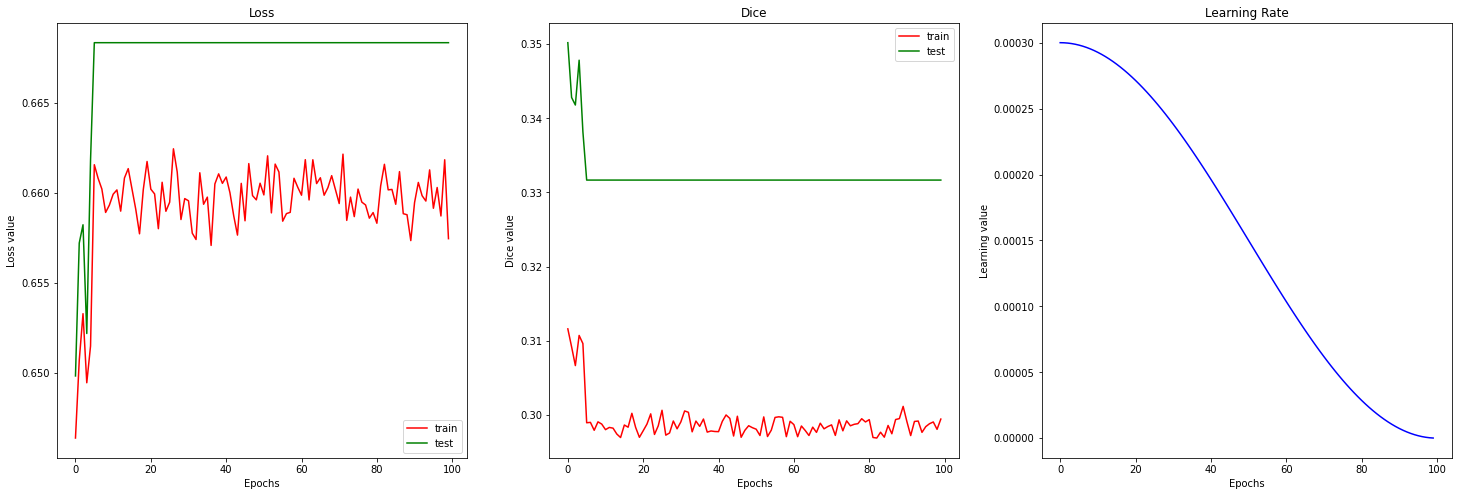

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(25, 8))
#plt.rcParams["figure.autolayout"] = True

# losses
axes[0].set_title('Loss')
axes[0].set(xlabel='Epochs')
axes[0].set(ylabel='Loss value')

axes[0].plot(history['epochs'], history['train_loss'], 'r', label='train')
axes[0].legend(loc='upper right')
axes[0].plot(history['epochs'], history['test_loss'], 'g', label='test')
axes[0].legend(loc='lower right')

# losses
axes[1].set_title('Dice')
axes[1].set(xlabel='Epochs')
axes[1].set(ylabel='Dice value')
axes[1].plot(history['epochs'], history['train_dice'], 'r', label='train')
axes[1].legend(loc='lower right')
axes[1].plot(history['epochs'], history['test_dice'], 'g', label='test')
axes[1].legend(loc='upper right')

# losses
axes[2].set_title('Learning Rate')
axes[2].set(xlabel='Epochs')
axes[2].set(ylabel='Learning value')
axes[2].plot(history['epochs'], history['lr'], 'b')

plt.plot()